# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient ascent. You will:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
 * Implement stochastic gradient ascent.
 * Compare convergence of stochastic gradient ascent with that of batch gradient ascent.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
SEED = 1

## Load and process review dataset

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')
products

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1


In [4]:
# add an empty column to dataframe using assign
products['word_count'] = ''

for i in range(len(products)):
    d = {}
    
    if pd.isna(products['review'][i]):
        products["word_count"][i] = d
    else:
        word_list = [word.strip(",.") for word in products['review'][i].lower().split()]
        for word in word_list:
            if word not in d:
                d[word] = 1
            d[word] += 1
        products["word_count"][i] = d

products

C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,review,rating,sentiment,word_count
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,"{'all': 3, 'of': 2, 'my': 2, 'kids': 3, 'have'..."
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,"{'we': 3, 'wanted': 3, 'to': 3, 'get': 2, 'som..."
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,"{'my': 2, 'daughter': 2, 'had': 2, 'her': 4, '..."
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"{'one': 2, 'of': 2, 'baby's': 2, 'first': 2, '..."
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,"{'very': 2, 'cute': 2, 'interactive': 2, 'book..."
...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,"{'my': 3, 'infant': 2, 'goes': 2, 'to': 4, 'a'..."
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,"{'pretty': 2, 'please': 2, 'open': 2, 'and': 3..."
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,"{'great': 2, '5-star': 3, 'product': 9, 'but':..."
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,"{'when': 3, 'i': 4, 'received': 2, 'the': 13, ..."


In [5]:
import json
with open('important_words.json', 'r') as f: 
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

#important_words

In [6]:
for word in important_words:
    def countwords(word_count):
        count = 0
        if word in word_count:
            count = word_count[word]
        return count
    
    products[word] = products['word_count'].apply(countwords)
    
products

,name,review,rating,sentiment,word_count,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,"{'all': 3, 'of': 2, 'my': 2, 'kids': 3, 'have'...",0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,"{'we': 3, 'wanted': 3, 'to': 3, 'get': 2, 'som...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,"{'my': 2, 'daughter': 2, 'had': 2, 'her': 4, '...",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"{'one': 2, 'of': 2, 'baby's': 2, 'first': 2, '...",0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,"{'very': 2, 'cute': 2, 'interactive': 2, 'book...",0,0,2,0,0,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,"{'my': 3, 'infant': 2, 'goes': 2, 'to': 4, 'a'...",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,"{'pretty': 2, 'please': 2, 'open': 2, 'and': 3...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,"{'great': 2, '5-star': 3, 'product': 9, 'but':...",0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,"{'when': 3, 'i': 4, 'received': 2, 'the': 13, ...",0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split data into training and validation sets

In [7]:
train_data, validation_data = train_test_split(products, train_size=.9, random_state=SEED)

## Convert SFrame to NumPy array

Just like in the earlier assignments, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [8]:
def get_numpy_data(data_frame, features, label):
    data_frame['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_frame[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_frame[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We will use the **same code** as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [10]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 assignment that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 assignment, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 
Complete the following code block:

In [11]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    return derivative

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [12]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


**Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [13]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 1.0")

Gradient single data point: 1.0
           --> Should print 1.0


## Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters.  In an optional video, we discussed the details of a simple change that allows us to use a **mini-batch** of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


**Computing the gradient for a "mini-batch" of data points**

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [14]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


## Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Complete the following function to fit a logistic regression model using gradient ascent:

In [15]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:],coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator =  (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size*derivative*(1./batch_size)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [16]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.00000000
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000004
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = 0.00000000
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.03641382
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.00243605
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.00000000
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = 0.00000000
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.02317478
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.00980246
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = 0.00000000


## Log likelihood plots for stochastic gradient ascent

In [17]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.66099870
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.66467229
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.64784594
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.64392241
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.64927922
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.62839493
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.62915031
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.61955671
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.61852227
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.60737972
Iteration   10: Average log likelihood (of data points in batch [01000

In [18]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

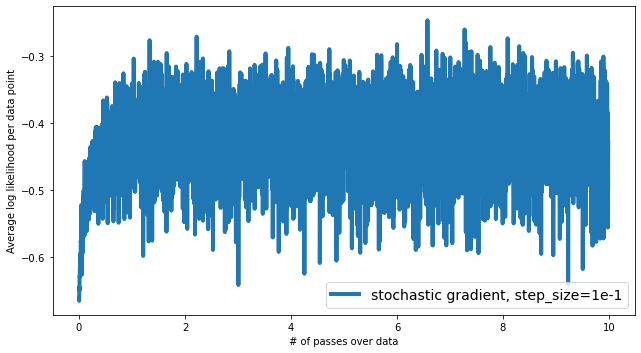

In [19]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

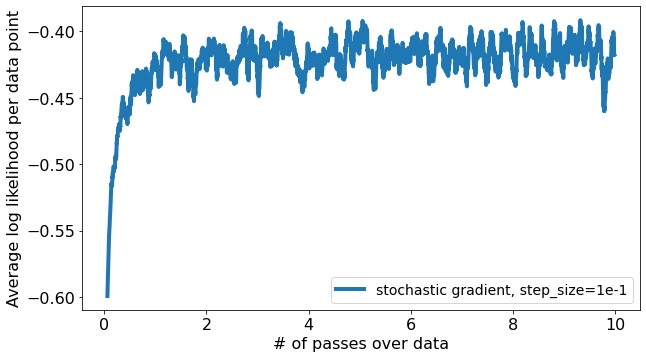

In [20]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')